In [1]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import numpy as np

import utility_functions as fn

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Initialization

In [2]:
# manually define building names
buildingnames = ['YUAG',
                 'Berkeley',
                 'Hopper',
                 '304Elm',
                 'Davenport',
                 '38HH',
                 '320Temple',
                 '53Wall',
                 'Sprague',
                 'Malone',
                 'Trumbull',
                 '17HH']

In [3]:
# read elec data from csv into a new dataframe
raw = pd.read_csv('data/elec_raw.csv',index_col=0,na_values=['#########'])

# remove precalculated demand values, which tend to be bugged
raw = raw.drop(raw.columns[np.arange(0,len(buildingnames)*2,2)], axis=1)

# reindex appropriately by hourly datetime
raw.index = pd.to_datetime(raw.index,format='%a %m/%d/%y %H:00')

# add missing rows by full reindexing
correct_dt = pd.DatetimeIndex(start='2018-01-01 00:00:00',end='2018-07-27 23:00:00',freq='h')
raw = raw.reindex(index=correct_dt)

# rename columns
raw.columns = buildingnames

In [4]:
# remove impossible outliers based on negative percent change
raw_head = raw.iloc[0]
raw = raw.where(raw.pct_change(limit=1)>0)
raw.iloc[0] = raw_head

In [5]:
# interpolate gaps in consumption data 6 hours and shorter, optional
for k in raw.columns:
    raw[k] = fn.limited_impute(raw[k],6)

## Error Identification & Removal

In [6]:
# create a new dataframe for hourly demand (kW)
demand = raw.diff().drop(raw.index[0])

# save head to replace later
demand_head = demand.iloc[0:4]

errors = demand.isnull().sum()
print('Missing values:')
print(errors)

# fn.plot_all(demand,'2018-01-01 01:00:00','2018-07-27 23:00:00')

Missing values:
YUAG          86
Berkeley       0
Hopper         0
304Elm        86
Davenport    903
38HH           0
320Temple     89
53Wall        80
Sprague        0
Malone        79
Trumbull      80
17HH          81
dtype: int64


New missing values from this step:
YUAG         0
Berkeley     0
Hopper       0
304Elm       0
Davenport    0
38HH         0
320Temple    0
53Wall       0
Sprague      0
Malone       0
Trumbull     0
17HH         0
dtype: int64


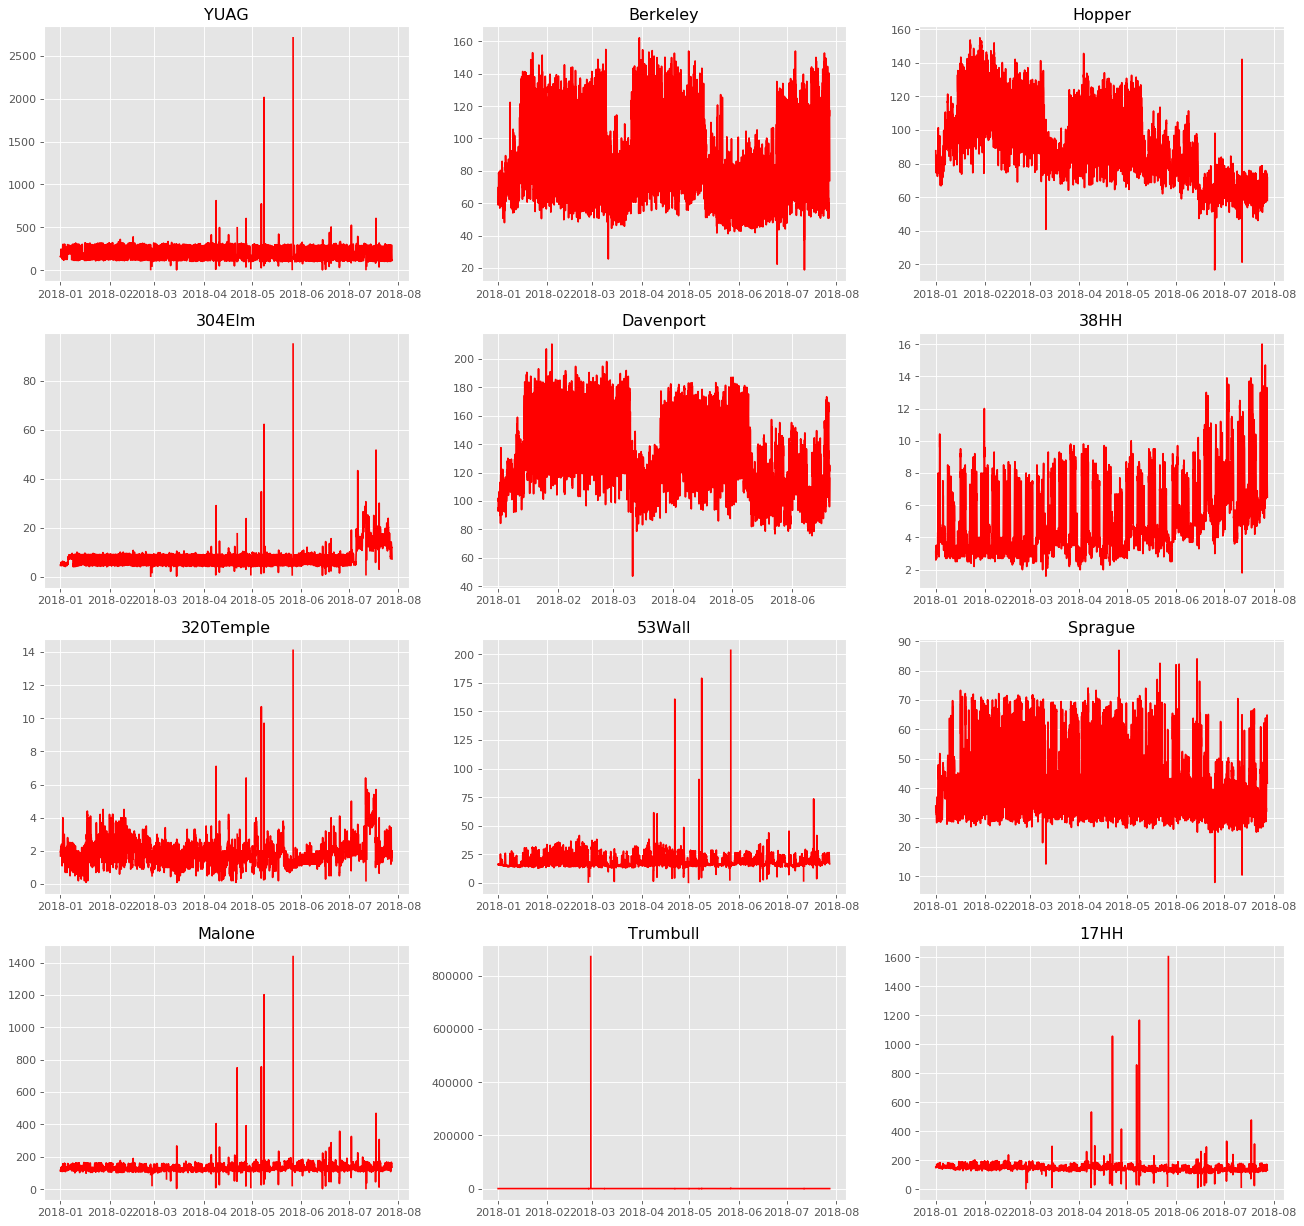

In [7]:
# remove huge statistical outliers
# demand = demand.where(demand > demand.median() - 2.5*demand.std())
# demand = demand.where(demand < demand.median() + 5*demand.std())

new_errors = demand.isnull().sum() - errors
print('New missing values from this step:')
print(new_errors)
errors = demand.isnull().sum()

fn.plot_all(demand,'2018-01-01 01:00:00','2018-07-27 23:00:00')

New missing values from this step:
YUAG          31
Berkeley      39
Hopper         9
304Elm       113
Davenport     20
38HH          29
320Temple    207
53Wall        45
Sprague       37
Malone        36
Trumbull      53
17HH          25
dtype: int64


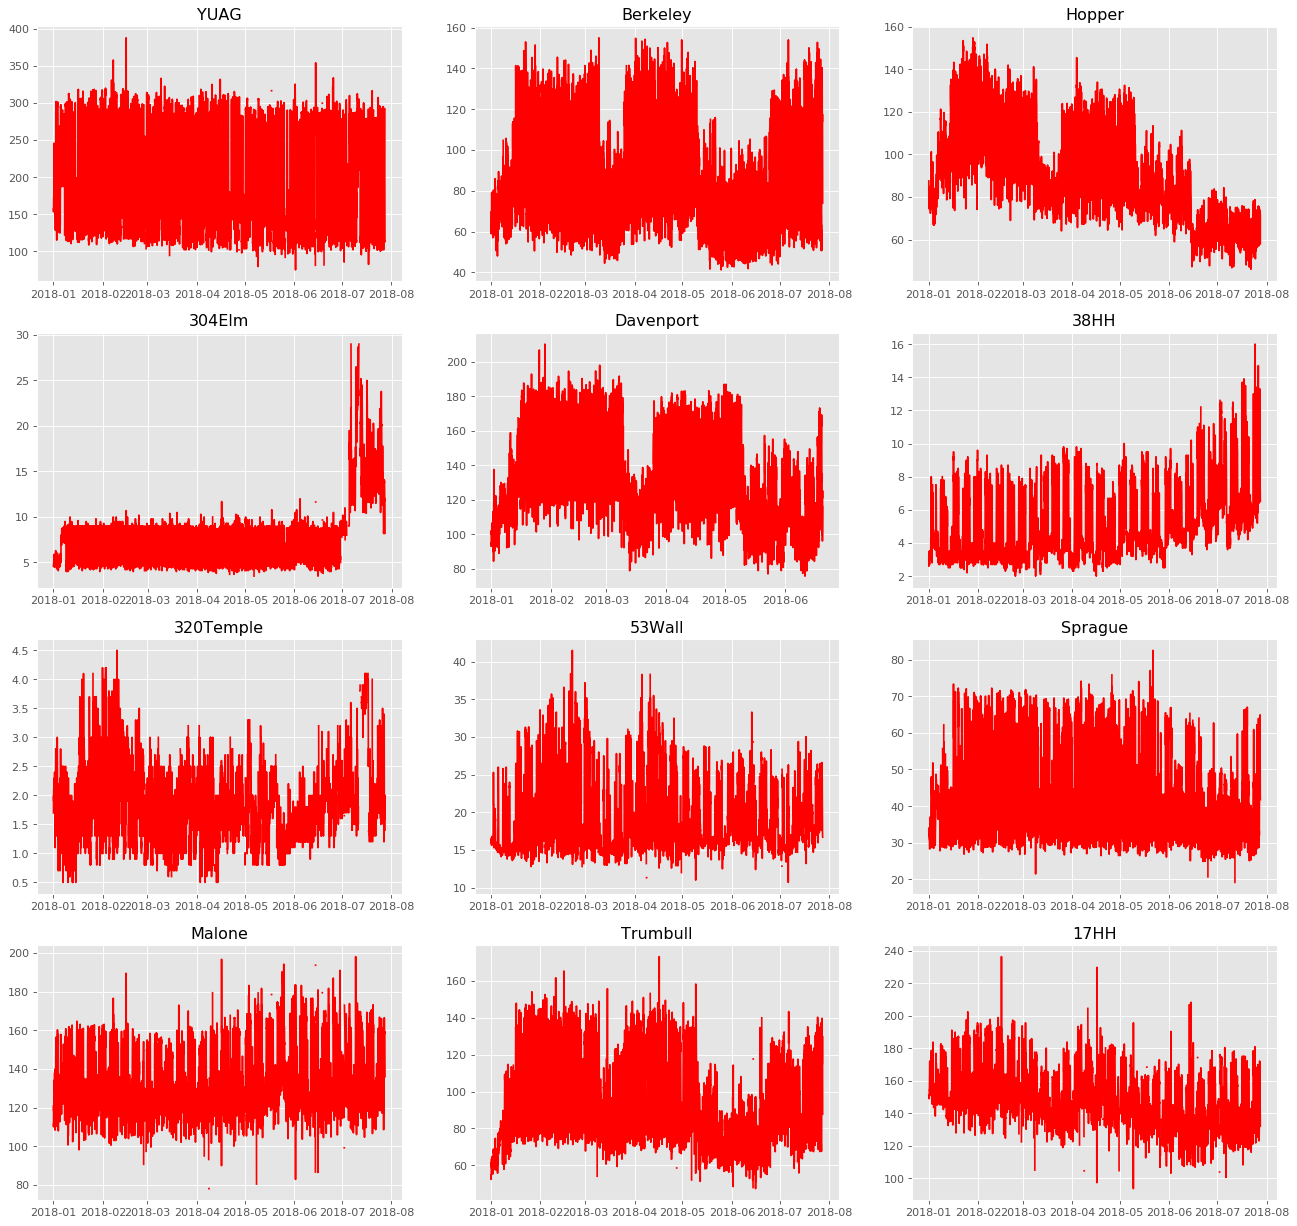

In [9]:
# remove errors by rolling min and max in 15-day chunks
chunk_size = 360
i=0

while i < len(demand):
    end = i+chunk_size
    if end > len(demand): end = len(demand)
    demand[i:end].where(demand[i:end] > demand[i:end].rolling(18).min().median()*0.7, inplace=True)
    demand[i:end].where(demand[i:end] < demand[i:end].rolling(18).max().median()*1.3, inplace=True)
    i = i+chunk_size


new_errors = demand.isnull().sum() - errors
print('New missing values from this step:')
print(new_errors)
errors = demand.isnull().sum()

fn.plot_all(demand,'2018-01-01 01:00:00','2018-07-27 23:00:00')

## Imputation of missing values

In [ ]:
dense = demand.copy(deep=True)

# interpolate gaps shorter than 6 hours
for k in dense.columns:
    dense[k] = fn.limited_impute(dense[k],6)

print('Number of missing values remaining:')
print(dense.isnull().sum())

fn.plot_all(dense,'2018-03-05 01:00:00','2018-03-10 23:00:00')

In [ ]:
# drop 320Temple for now, data in July is too messy for sinusoidal interpolation
dense = dense.drop('320Temple', axis=1)

# interpolate gaps longer than 6 hours using least-squares optimized sinusoidal fit
for k in dense.columns:
    dense[k] = fn.sine_impute(dense[k])

# print('Number of missing values remaining:')
# print(dense.isnull().sum())

fn.plot_all(dense,'2018-03-05 01:00:00','2018-03-10 23:00:00')

## Export

In [ ]:
# replace head for final export
dense.iloc[0:4] = demand_head.drop('320Temple',axis=1)

# export clean data to csv
# dense.round(1).to_csv('data/elec_clean.csv')

### unused code below

In [ ]:
# OLD ATTEMPT to find outliers using tuner values

# comp = demand.take([1], axis=1)
# comp['rolling'] = comp.loc[:,'Berkeley'].rolling(4,min_periods=1).median()
# # demand.rolling(4,min_periods=1).median()*0.5

# comp['rollmin'] = comp.loc[:,'Berkeley'].rolling(8,min_periods=6).min()

# # fn.plot_all(comp,'2018-03-14 00:00:00','2018-06-20 00:00:00')

# fn.plot_feature(comp,'rollmin','2018-01-02 00:00:00','2018-07-25 00:00:00')

# comp['rollmin'].median()-comp['rollmin'].std()

# max_tuner = 1 # here i want higher values clipping more points
# min_tuner = 1

# # demand.std()/demand.median() # here high values indicate volatile, 

# demand.where(demand > demand.rolling(8,min_periods=4).min() - (min_tuner - demand.std()/demand.median()))
                      
# demand.where(demand < demand.rolling(8,min_periods=4).max() + (max_tuner - demand.std()/demand.median()))

# fn.plot_all(demand,'2018-01-02 00:00:00','2018-07-25 00:00:00')
# demand.isnull().sum()


In [ ]:
# ANOTHER OLD ATTEMPT TO REMOVE CONSUMPTION OUTLIERS

# method to find outliers, not currently implemented
# tau = 0.0005 * (raw.max()-raw.min())
# raw = raw.where(raw.pct_change(limit=1)<tau)

In [ ]:
# iterative (SLOW) method to remove single spikes, unsure how helpful it is

# for k in demand.columns:
#     for i in range(len(demand)-1):
#         if (abs(demand.pct_change()[k][i]) > 0.5) & (abs(demand.pct_change()[k][i+1]) > 0.5):
#             demand[k][i] = np.NaN


In [ ]:
# remove errors with max/min cutoff method, useful for steam data but not here

max_cutoff = (demand.resample('0.5D').max().rolling(14,center=True).median()
                    .reindex_like(demand).interpolate(method='linear').fillna(method='bfill')*2
             )

min_cutoff = (demand.resample('0.5D').min().rolling(14,center=True).median()
                    .reindex_like(demand).interpolate(method='linear').fillna(method='bfill')*0.3
             )

demand.where(demand < max_cutoff, inplace=True)
demand.where(demand >= min_cutoff, inplace=True)
